**CLASS**: Naive Bayes SMS spam classifier using sklearn

Data source: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [4]:
## READING IN THE DATA

# read tab-separated file using pandas
import pandas as pd
%matplotlib inline

In [5]:
df = pd.read_table('../data/sms.tsv',
                   sep='\t', header=None, names=['label', 'msg'])

In [6]:
# examine the data
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


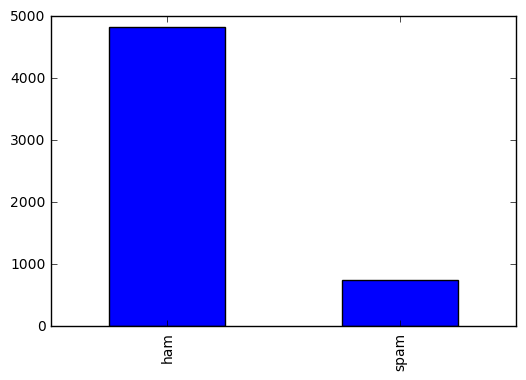

In [7]:
df.label.value_counts().plot(kind='bar')

In [8]:
# Get the null accuracy rate
df.label.value_counts() / df.shape[0]

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [9]:
df.msg.describe()

count                       5572
unique                      5169
top       Sorry, I'll call later
freq                          30
Name: msg, dtype: object

In [10]:
# convert label to a quantitative binary variable
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# split into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.msg, df.label, random_state=1)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# start with a simple example
train_simple = ['call you tonight',
                'Call me a cab',
                'please call me... PLEASE 44!']

# learn the 'vocabulary' of the training data
vect = CountVectorizer()
train_simple_dtm = vect.fit_transform(train_simple)
vect.get_feature_names()

[u'44', u'cab', u'call', u'me', u'please', u'tonight', u'you']

In [13]:
# transform training data into a 'document-term matrix'
train_simple_dtm = vect.transform(train_simple)
train_simple_dtm

<3x7 sparse matrix of type '<type 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [14]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(train_simple_dtm.toarray(), columns=vect.get_feature_names())

,44,cab,call,me,please,tonight,you
0,0,0,1,0,0,1,1
1,0,1,1,1,0,0,0
2,1,0,1,1,2,0,0


In [15]:
# transform testing data into a document-term matrix (using existing vocabulary, notice don't is missing)
test_simple = ["please don't call me"]
test_simple_dtm = vect.transform(test_simple)
test_simple_dtm.toarray()
pd.DataFrame(test_simple_dtm.toarray(), columns=vect.get_feature_names())

,44,cab,call,me,please,tonight,you
0,0,0,1,1,1,0,0


In [16]:
## REPEAT PATTERN WITH SMS DATA

# instantiate the vectorizer
vect = CountVectorizer()

# learn vocabulary and create document-term matrix in a single step
train_dtm = vect.fit_transform(X_train)
train_dtm

<4179x7456 sparse matrix of type '<type 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [17]:
# transform testing data into a document-term matrix
test_dtm = vect.transform(X_test)
test_dtm

<1393x7456 sparse matrix of type '<type 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

In [18]:
# store feature names and examine them
train_features = vect.get_feature_names()
len(train_features)
train_features[:10], train_features[-10:]

([u'00',
  u'000',
  u'008704050406',
  u'0121',
  u'01223585236',
  u'01223585334',
  u'0125698789',
  u'02',
  u'0207',
  u'02072069400'],
 [u'zed',
  u'zeros',
  u'zhong',
  u'zindgi',
  u'zoe',
  u'zoom',
  u'zouk',
  u'zyada',
  u'\xe8n',
  u'\u3028ud'])

In [19]:
## MODEL BUILDING WITH NAIVE BAYES
## http://scikit-learn.org/stable/modules/naive_bayes.html

# train a Naive Bayes model using train_dtm
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
# make predictions on test data using test_dtm
preds = nb.predict(test_dtm)
preds

array([0, 0, 0, ..., 0, 1, 0])

In [21]:
# compare predictions to true labels
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)
print metrics.confusion_matrix(y_test, preds)

0.988513998564
[[1203    5]
 [  11  174]]


![Slope-intercept](images/1.png)

![Slope-intercept](images/2.png)

![Slope-intercept](images/3.png)

![Slope-intercept](images/4.png)

![Slope-intercept](images/5.png)

In [22]:
# predict (poorly calibrated) probabilities and calculate AUC
probs = nb.predict_proba(test_dtm)[:, 1]
probs
print metrics.roc_auc_score(y_test, probs)

0.986643100054


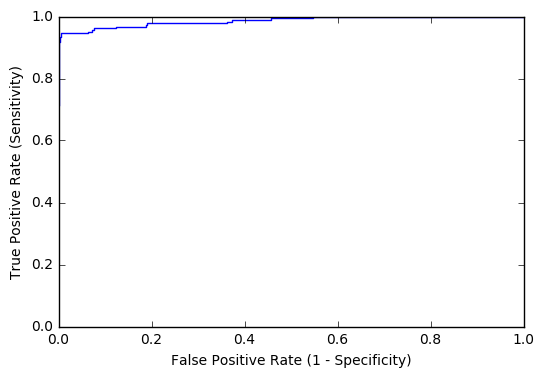

In [24]:
## ROC CURVES and AUC
import matplotlib.pyplot as plt

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [27]:
## COMPARE NAIVE BAYES AND LOGISTIC REGRESSION
## USING ALL DATA AND CROSS-VALIDATION
vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
# create a document-term matrix using all data
all_dtm = vect.fit_transform(df.msg)
print len(vect.get_feature_names())

# instantiate logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# compare AUC using cross-validation
# note: this is slightly improper cross-validation... can you figure out why?
from sklearn.cross_validation import cross_val_score

from datetime import datetime

65438


In [28]:
now = datetime.now()
mean = cross_val_score(logreg, all_dtm, df.label, cv=10, scoring='roc_auc').mean()
print (datetime.now()-now).total_seconds(), "Seconds for logistic regression", mean

2.298188 Seconds for logistic regression 0.990013516184


In [29]:
now = datetime.now()
mean = cross_val_score(nb, all_dtm, df.label, cv=10, scoring='roc_auc').mean()
print (datetime.now()-now).total_seconds(), "Seconds for naive bayes", mean

0.584823 Seconds for naive bayes 0.9938639119


In [31]:
'''
Model evaluation metrics (confusion matrix, ROC/AUC)
'''

## READ DATA AND SPLIT INTO TRAIN/TEST

# read in the data
import pandas as pd
data = pd.read_csv('../data/Default.csv')
data.head()

,default,student,balance,income
0,0,No,729.526495,44361.62507
1,0,Yes,817.180407,12106.13470
2,0,No,1073.549164,31767.13895
3,0,No,529.250605,35704.49394
4,0,No,785.655883,38463.49588


In [32]:
# create X and y
X = data[['balance']]
y = data.default

In [33]:
# split into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
# create logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
# predict and calculate accuracy in one step
logreg.score(X_test, y_test)

0.9748

In [36]:
# predict in one step, calculate accuracy in a separate step
preds = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)

0.9748


In [37]:
# compare to null accuracy rate
y_test.mean()
1 - y_test.mean()

0.9684

In [38]:
## CONFUSION MATRIX

# print confusion matrix
print metrics.confusion_matrix(y_test, preds)

[[2416    5]
 [  58   21]]


In [39]:
# nicer confusion matrix
from nltk import ConfusionMatrix
print ConfusionMatrix(list(y_test), list(preds))

  |    0    1 |
--+-----------+
0 |<2416>   5 |
1 |   58  <21>|
--+-----------+
(row = reference; col = test)



(array([  2.23000000e+03,   1.23000000e+02,   6.30000000e+01,
          2.90000000e+01,   2.30000000e+01,   1.10000000e+01,
          1.00000000e+01,   6.00000000e+00,   1.00000000e+00,
          4.00000000e+00]),
 array([  1.87839293e-04,   8.91943925e-02,   1.78200946e-01,
          2.67207499e-01,   3.56214052e-01,   4.45220605e-01,
          5.34227159e-01,   6.23233712e-01,   7.12240265e-01,
          8.01246818e-01,   8.90253371e-01]),
 <a list of 10 Patch objects>)

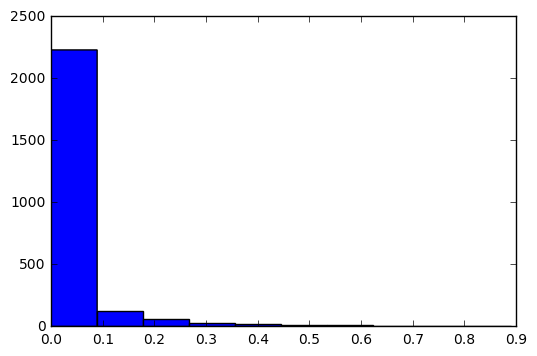

In [40]:
# predict probabilities
probs = logreg.predict_proba(X_test)[:, 1]
plt.hist(probs)

In [41]:
# use 0.5 cutoff for predicting 'default'
import numpy as np
preds = np.where(probs > 0.5, 1, 0)
print ConfusionMatrix(list(y_test), list(preds))

  |    0    1 |
--+-----------+
0 |<2416>   5 |
1 |   58  <21>|
--+-----------+
(row = reference; col = test)



In [42]:
# change cutoff for predicting default to 0.2
preds = np.where(probs > 0.2, 1, 0)
print ConfusionMatrix(list(y_test), list(preds))

  |    0    1 |
--+-----------+
0 |<2340>  81 |
1 |   34  <45>|
--+-----------+
(row = reference; col = test)



In [43]:
# check accuracy
print metrics.accuracy_score(y_test, preds)


0.954


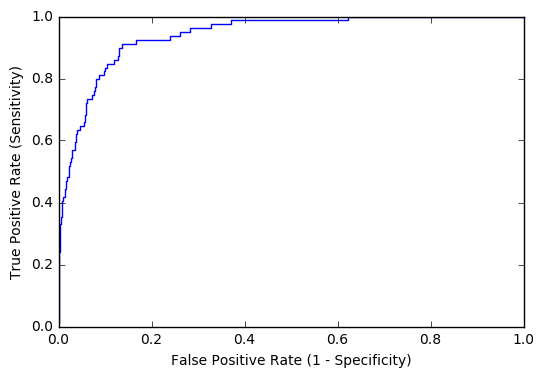

In [44]:
## ROC CURVES and AUC

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [45]:
# calculate AUC
print metrics.roc_auc_score(y_test, probs)

0.941011926236


In [62]:
# use AUC as evaluation metric for cross-validation
from sklearn.cross_validation import cross_val_score
X = data[['balance']]
y = data.default
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.94819099843061938

In [67]:
# compare to a model with an additional feature
X = data[['balance', 'income']]
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.59503752064417714

In [68]:
# compare to a model with an additional feature
X = data[['balance', 'income']]
cross_val_score(nb, X, y, cv=10, scoring='roc_auc').mean()

0.74846895568813498

In [48]:
# ROC/AUC are very meaningful when:
# 1. class sizes are inbalanced
# 2. comparing across different binary classification models